### Libraries & settings

In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Settings
np.random.seed(1997)
column_number = '44'

### Functions

In [63]:
# use A.dot(b) when b may be a scalar
# how to deal with scalars??? inversion, transpose, multiplication

def multiv_norm_mean(y, X, b, B):
    mean = (X.T@X + B.I).I @ (X.T@y + (B.I).dot(b))
    return(mean)

def multiv_norm_variance(X, B, Sigma_squared):
    Var = Sigma_squared * (X.T@X + B.I).I
    return(Var)

### Open data

In [64]:
data_path = '/Users/maxim_anisimov/Desktop/GitHub/data/'

returns = pd.read_excel(data_path + 'returns.xls')
Jan = pd.read_excel(data_path + 'Jan.xls')
rf = pd.read_excel(data_path + 'rf.xls')
rm = pd.read_excel(data_path +'rm.xls')

df = pd.DataFrame({'const': np.ones(len(rm)),
                   '3M yield change': rf[rf.columns[2]],
                   'S&P 500 log return': rm[rm.columns[2]],
                   'Jan': Jan['Jan']})

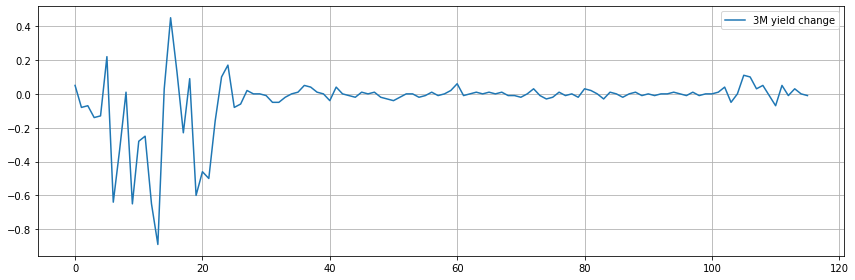

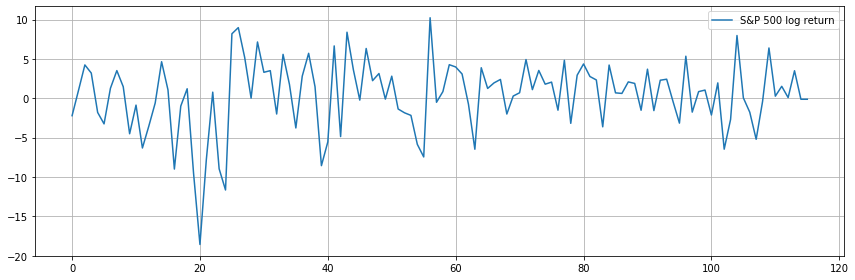

In [65]:
for col in ['3M yield change', 'S&P 500 log return']:
    
    df[[col]].plot(figsize=(12,4))
    plt.grid()
    plt.tight_layout()
    plt.show();

### Data Preprocessing

Model: $$r_t =β_0 +β_1 r^f_t +β_2 r^m_t +β_3 \text{Jan}_t +ε_t$$

Prior:
$$
\beta|\sigma^2 \sim N(0, \sigma^2 I_4),\\    
p(\sigma^2) ∝ \sigma^{−2}
$$

In [66]:
y = returns.iloc[:,44+1]

In [67]:
data = df[['3M yield change', 'S&P 500 log return', 'Jan']]
data['return_lag1'] = np.ravel(y)
data['return'] = data['return_lag1'].shift(-1)
data.tail()

,3M yield change,S&P 500 log return,Jan,return_lag1,return
111,0.05,1.520837,0,-0.155063,-2.705418
112,-0.01,0.091051,0,-2.705418,6.511632
113,0.03,3.499043,0,6.511632,14.104715
114,0.00,-0.121999,0,14.104715,-0.938484
115,-0.01,-0.123521,0,-0.938484,NaN


In [68]:
data = data[:len(data)-1]
data.tail()

,3M yield change,S&P 500 log return,Jan,return_lag1,return
110,-0.07,0.269576,0,0.465912,-0.155063
111,0.05,1.520837,0,-0.155063,-2.705418
112,-0.01,0.091051,0,-2.705418,6.511632
113,0.03,3.499043,0,6.511632,14.104715
114,0.00,-0.121999,0,14.104715,-0.938484


In [69]:
data = data[['return_lag1', '3M yield change', 'S&P 500 log return', 'Jan', 'return']]
data.head()

,return_lag1,3M yield change,S&P 500 log return,Jan,return
0,-8.321062,0.05,-2.208834,0,3.548184
1,3.548184,-0.08,0.993051,0,-4.191411
2,-4.191411,-0.07,4.237984,0,5.421438
3,5.421438,-0.14,3.203072,0,-4.458143
4,-4.458143,-0.13,-1.797694,0,-5.924083


In [70]:
# Gibbs sampler parameters
n_sim = 10**5 # number of simulations (size of sample of final posterior sample)
n_burn = 10**3 # burn-in size
k = 10 # thin value

b = np.matrix([[0],[0],[0],[0]]) # mean beta prior
B = np.asmatrix(np.diag([1,1,1,1])) # prior proportional matrix
beta_initial = np.matrix([[0],[0],[0],[0]]) # initial beta values for the draws in the first simulation

y = np.asmatrix(data['return']).T
X = np.asmatrix(data[['return_lag1', '3M yield change', 'S&P 500 log return', 'Jan',]])

Time = y.shape[0]
N = X.shape[1]

In [71]:
train_size = int(np.ceil(0.7*X.shape[0]))

In [72]:
X_test = X[train_size:].copy()
X = X[:train_size]

In [73]:
y_test = y[train_size:].copy()
y = y[:train_size]

Then the number of ALL simulations is $n_{sim}*k + n_{burn}$

### Simulations

Draw #1
Draw #100100
Draw #200200
Draw #300300
Draw #400400
Draw #500500
Draw #600600
Draw #700700
Draw #800800
Draw #900900
Draw #1001000


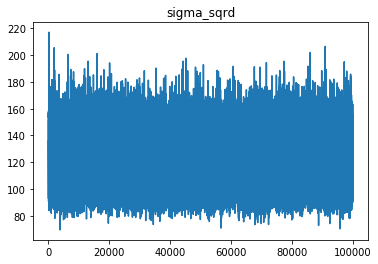

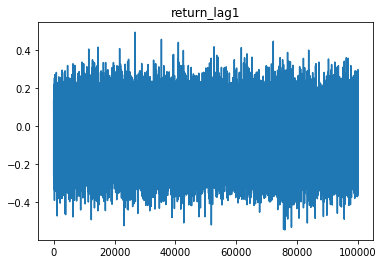

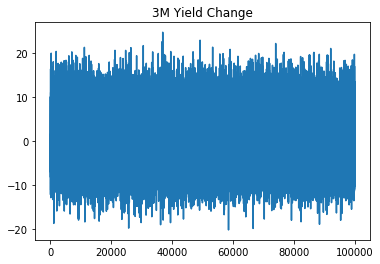

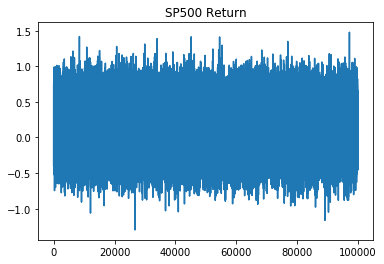

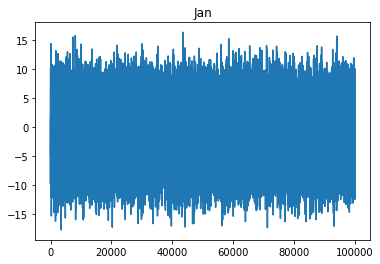

Posterior means: [ 1.18580512e+02 -5.10236070e-02  1.28857115e+00  1.44584342e-01
 -1.17109354e+00]
Posterior variance: [[2.39621854e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.23040476e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.69882830e+01 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.73401830e-02
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.71860366e+01]]
Posterior Odd of the 3M Yield Change: 1.491528802072952


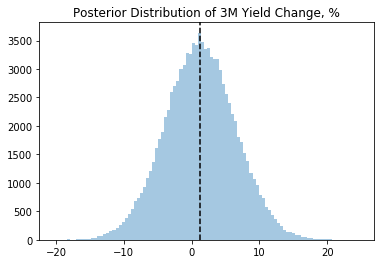

In [74]:
# matrix to save draws
draw_matrix = np.empty((n_burn+n_sim*k, 5))
draw_matrix[:] = np.nan 
colnames_draw_matrix = ['sigma_sqrd', 'return_lag1', '3M Yield Change', 'SP500 Return', 'Jan']

# Prepare mean of the prior
beta_mean = multiv_norm_mean(y, X, b, B)

# create n_sim*k + n_burn draws
for n_draw in range(n_sim*k+n_burn):
    
    if (n_draw+1) % ( (n_sim*k+n_burn)//10 ) == 0:
        print("Draw #" + str(n_draw+1))
        
    if n_draw == 0:
        print("Draw #" + str(n_draw+1))
        #first draw -> use initial betas
        beta_prev = beta_initial
    else:
        # there were previous draws -> take them to simulate sigma^2
        beta_prev = np.asmatrix(draw_matrix[n_draw-1, 1:5]).T
  
    ### draw sigma_sqrd conditional on betas and y
    RSS_prev = (y - X@beta_prev).T @ (y - X@beta_prev)  # construct residual sum of squares
    mu_IG = ( RSS_prev + (b-beta_prev).T @ np.linalg.inv(B) @ (b-beta_prev) )[0,0]
    chisq_rv = np.random.chisquare(df=Time+k, size=1)[0] # random chi-squared rv with T+k degrees of freedom
    sigma_sqrd_draw = mu_IG/chisq_rv
  
    # draw betas conditional on sigma_squared_draw and beta
    beta_var = multiv_norm_variance(X=X, B=B, Sigma_squared=sigma_sqrd_draw)
    beta_draw = np.random.multivariate_normal(mean=beta_mean.T.tolist()[0], cov=beta_var, size=1)[0]
  
    current_draw = np.append(sigma_sqrd_draw, beta_draw)
    #print(current_draw)
  
    draw_matrix[n_draw] = current_draw

    
draw_matrix = draw_matrix[n_burn:(n_burn+n_sim*k)] # discard burn-in sample
# Is correlation of draws present?
#for (col_name in colnames(draw.matrix)){
#  acf(draw.matrix[,col_name], main=col_name)
#}
#"Significant first AC in sigma squared"

#%% Thinning
draw_matrix =  draw_matrix[::k]
# check whether thinning helps
#for (col_name in colnames(draw.matrix)){
#  acf(draw.matrix[,col_name], main=col_name)
#}
# Now, no significant spikes at all

#%% Traceplots
for col_num in range(draw_matrix.shape[1]):
    plt.plot(draw_matrix[:,col_num])
    plt.title(colnames_draw_matrix[col_num])
    plt.show();

#%% Posterior Results
post_mean = np.mean(draw_matrix, axis=0)
print('Posterior means:', post_mean)
# posterior population variance with correction
post_var = np.diag(np.var(draw_matrix, axis=0)) * (draw_matrix.shape[0]-1)/draw_matrix.shape[0]
print('Posterior variance:', post_var)

# Posterior Odd
print('Posterior Odd of the 3M Yield Change:',
      np.sum(draw_matrix[:, 2] > 0) / np.sum(draw_matrix[:, 2] < 0))

# Posterior Distribution of 3M Yield Change
sns.distplot(draw_matrix[:,2], kde=False, bins=100)
plt.axvline(post_mean[2], color='k', ls='--')
plt.title('Posterior Distribution of 3M Yield Change, %');